In [1]:
import sys
sys.path.insert(0, '../')

import gymnasium as gym
print(f"Gym Version = {gym.__version__}")

import AddictiveReward

import numpy as np

from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional

Gym Version = 0.27.0


In [2]:
env = gym.make('AddictiveEnv_v2')

## AGENTE MF

In [24]:
class MFLearningAgent:
    def __init__(self, learning_rate: float,  initial_epsilon: float, discount_factor: float = 0.9):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon

        self.training_error = []
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values
    
    # def update_value_iteration(self, state, action, reward, next_state):
    #     old_value = self.q_values[state, action] 
    #     next_max = np.max(self.value_iteration[next_state, :])
    #     self.q_values[state, action] =  (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max) 

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)
        
    # def decay_epsilon(self):
    #    self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [25]:
lr = 0.01
n_episodes = 200
se = 0.1


agentMF = MFLearningAgent(
    learning_rate = lr,
    initial_epsilon = se,
)


In [17]:
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
addiction_states = []
total_reward = []

In [20]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    addicted = 0
    r = 0
    # play one episode
    while not done:
        action = agentMF.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agentMF.update(obs, action, reward, terminated, next_obs)
        
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        r += reward
        if obs == 4:
            addicted += 1 
    addiction_states.append(addicted)
    total_reward.append(r)
    #agent.decay_epsilon()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.00it/s]


[[  0.           0.           0.           0.           0.        ]
 [  4.70086063   4.69983862   5.18434213   4.68906649   4.70208497]
 [  4.21995449   3.78841236   4.70030467   4.22383347   4.21796866]
 [  4.20054177   1.98420502   1.84578623   2.32992766   2.36989664]
 [-10.70611417 -10.70419911 -10.70001119 -10.9019202  -10.69858273]]


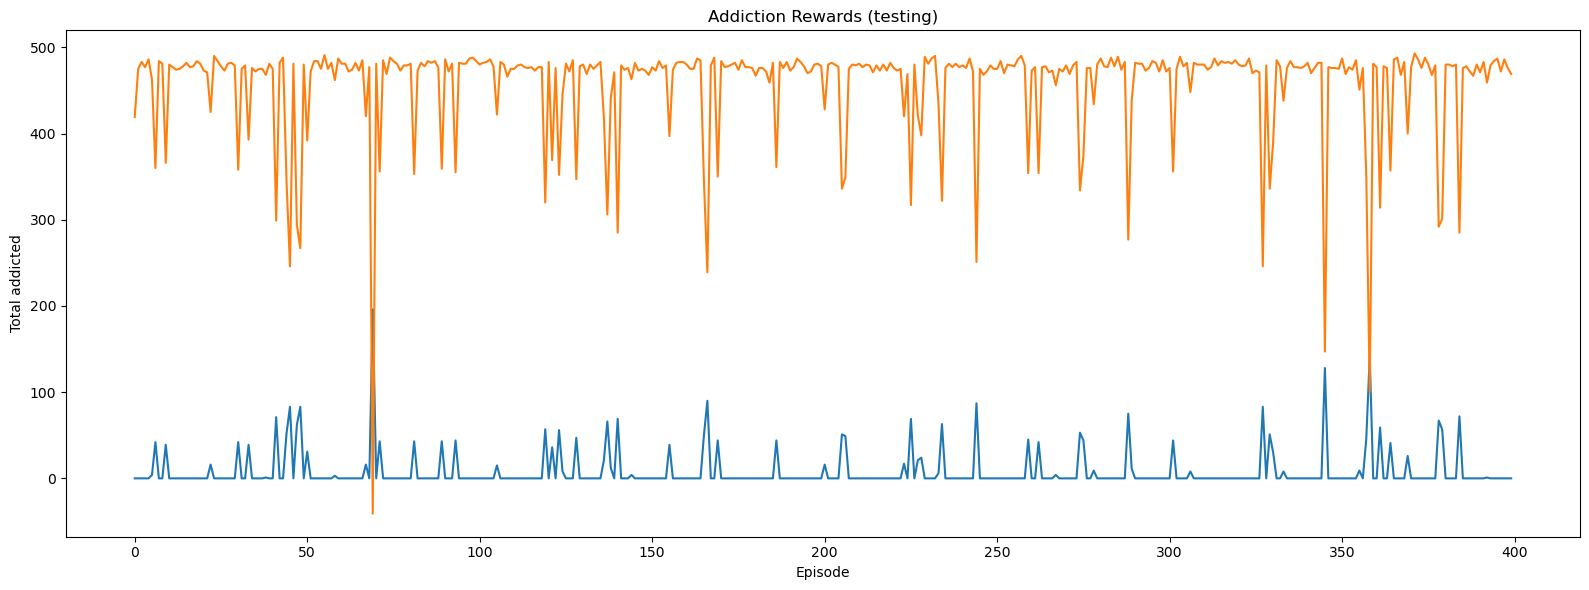

In [21]:
print(agentMF.q_values)
plt.figure(figsize=(16, 6))


plt.plot(addiction_states)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')

plt.plot(total_reward)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')

plt.tight_layout()
plt.show()

## AGENTE MB

In [33]:
import heapq
class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def is_empty(self):
        if self._queue  == []:
            return True
        return False
        
    def insert(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self):
        return heapq.heappop(self._queue)[-1]

In [34]:
class MBLearningAgent:
    def __init__(self, learning_rate: float,  initial_epsilon: float, discount_factor: float = 0.9, theta=0.01):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon

        self.transition_model = {} 
        self.initialize_transition_model()
        
        self.training_error = []
        
        self.pred_queue = PriorityQueue()
        self.theta = theta 
        self.upd = 0
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values
    
    def value_iteration(self, iter=100):
        epsilon = 0.1
        for _ in range(1, iter):
            delta = 0
            for state in range(1, env.observation_space.n):
                for action in range(0, env.action_space.n):
                    t = 0
                    for next_state in self.transition_model[state][action]:
                        probability = self.transition_model[state][action][next_state]['probability']
                        reward = self.transition_model[state][action][next_state]['reward']
                        t += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
                    self.q_values[state][action] = t
                     
                Vs = abs(self.q_values[state][action] - np.max(self.q_values[state]))
                delta = max(delta, Vs)
                
            if delta < epsilon and delta > 0:
                break

    def prioritized_sweeping(self, state, action, k = 5):
        self.calculate_sweep(state, action)
        
        while not self.pred_queue.is_empty() and self.upd < k:
            state = self.pred_queue.pop()
            
            for state_p in range(1, env.observation_space.n):
                for action_p in range(env.action_space.n): 
                    for next_state_p in self.transition_model[state_p][action_p]:
                        if next_state_p == state:
                            self.calculate_sweep(state_p, action_p)
                            

    def calculate_sweep(self, state, action):
        old_q = self.q_values[state][action]
        new_q = 0
        
        for next_state in self.transition_model[state][action]:
            probability = self.transition_model[state][action][next_state]['probability']
            reward = self.transition_model[state][action][next_state]['reward']
            new_q += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
        self.q_values[state][action] = new_q
        p = abs(new_q - old_q)
        if p > 0:
            self.upd += 1
            max_q = np.max(self.q_values[state])
            if old_q == max_q or new_q == max_q:
                 self.pred_queue.insert(state, p)
       
    
    
    
    def initialize_transition_model(self):
        for state in range(1, env.observation_space.n):
            self.transition_model[state] = {}
            for action in range(env.action_space.n):
                self.transition_model[state][action] = {}
                for next_state in range(env.observation_space.n):
                    self.transition_model[state][action][next_state] = {'count': 0, 'probability': 0, 'reward': 0}
                    
    def update_transition_model(self, state, action, next_state, reward):
        self.transition_model[state][action][next_state]['count'] += 1
        self.transition_model[state][action][next_state]['reward'] = reward
        self.calculate_transition_probabilities()
        
    
    def calculate_transition_probabilities(self):
        for state in range(1, env.observation_space.n):
            for action in range(env.action_space.n):
                total_count = sum(self.transition_model[state][action][next_state]['count'] for next_state in self.transition_model[state][action])
                for next_state in self.transition_model[state][action]:
                    
                    c = self.transition_model[state][action][next_state]['count']
                    if total_count == 0:
                        total_count = 1
                    self.transition_model[state][action][next_state]['probability'] = c / total_count
                    #if  self.transition_model[state][action][next_state]['probability'] != 0:
                    #    print(f"{state} {action} {next_state} { self.transition_model[state][action][next_state]['probability']}")
    
    

In [38]:
lr = 0.01
n_episodes = 1000
se = 0.1

agentMB = MBLearningAgent(
    learning_rate = lr,
    initial_epsilon = se,
)

addiction_states = []
total_reward = []

In [39]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    addicted = 0
    r = 0
    
    while not done:
        action = agentMB.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agentMB.update_transition_model(obs, action, next_obs, reward)
        agentMB.prioritized_sweeping(obs, action, 100)
        
        done = terminated or truncated
        obs = next_obs
        r += reward
        if obs == 4:
            addicted += 1 
    addiction_states.append(addicted)
    total_reward.append(r)
    #agent.decay_epsilon()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.03it/s]


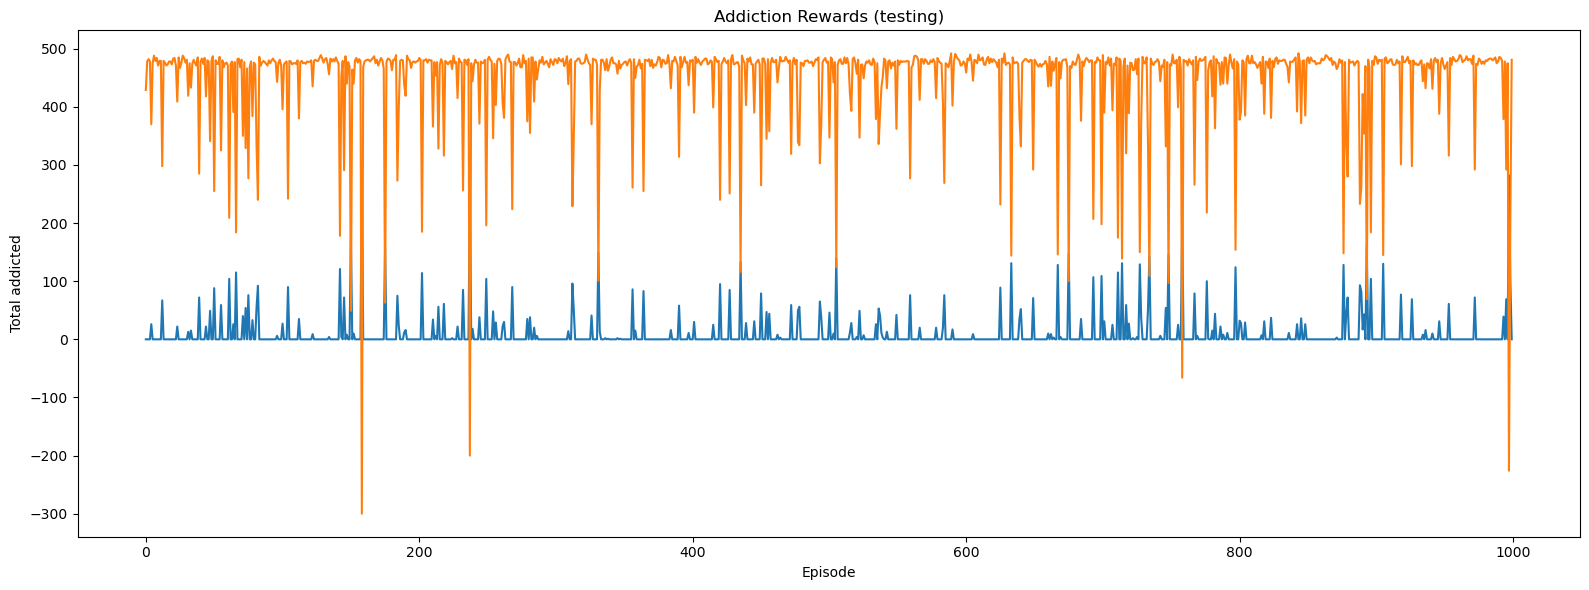

In [40]:
plt.figure(figsize=(16, 6))

plt.plot(addiction_states)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')

plt.plot(total_reward)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')

plt.tight_layout()
plt.show()

## MX Agent ##

In [50]:
class MXLearningAgent:
    def __init__(self, MF_agent, MB_agent, Beta):
        self.MF_agent = MF_agent
        self.MB_agent = MB_agent
        self.beta = Beta
        
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.Beta: # epsilon greedy 
            return np.argmax(self.MB_agent.get_action[state]) # Explore action space
        else:
            return np.argmax(self.MF_agent.get_action[state])  # Exploit learned values   

## Multi agent test ##

In [46]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.05
n_episodes = 50
se = 0.1
# creazione 900 agenti
print("creazione agenti")
nagenti = 100

for _ in range(nagenti):
    agent = MBLearningAgent(
        learning_rate = lr,
        initial_epsilon = se,
    )
    agents.append(agent)
    
print("agenti creati")

#timesteps
print("calcolo")

T = 20
#means, stds Addited
meansA = []
stdsA =  []
#means, stds Healthy
meansH = []
stdsH = []

for i in range(T):
    n = 1
    
    #percs Addicted and Healthy
    percsA = []
    percsH = []
    for agent in agents:
        obs, info = env.reset()
        done = False
        addicted = 0
        healthy = 0
        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            #agent.update(obs, action, reward, terminated, next_obs)
            agent.update_transition_model(obs, action, next_obs, reward)
            agent.prioritized_sweeping(obs, action)
            
            #conto stati
            if(next_obs == 4):
                addicted = addicted + 1
            if(next_obs == 1):
                healthy = healthy + 1
            
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
       
        #print(f"agente {n} healthy {healthy}")
        #print(f"agente {n} addicted {addicted}")
        #perc Addicted and Healthy
        percA = (addicted / (addicted + healthy))
        percH = (healthy / (addicted + healthy))
        #print(perc)
        percsA.append(percA)
        percsH.append(percH)
        n = n + 1
        
    #addicted
    meanA = np.mean(percsA)
    stdA = np.std(percsA)
    meansA.append(meanA)
    stdsA.append(stdA)

    addiction_states.append(meanA)
    #healthy
    meanH = np.mean(percsH)
    stdH = np.std(percsH)
    meansH.append(meanH)
    stdsH.append(stdH)

#addicted
print(meansA)
print(stdsA)

#healthy
print(meansH)
print(stdsH)

creazione agenti
agenti creati
calcolo


KeyboardInterrupt: 

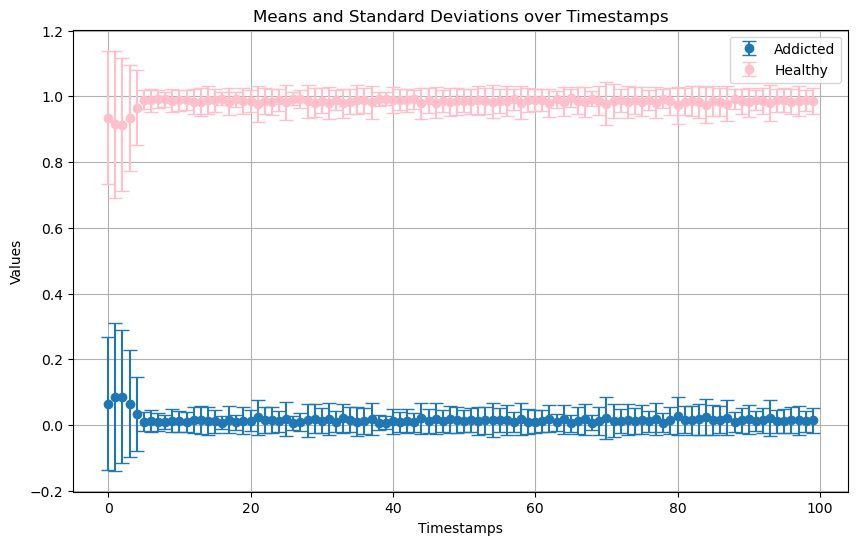

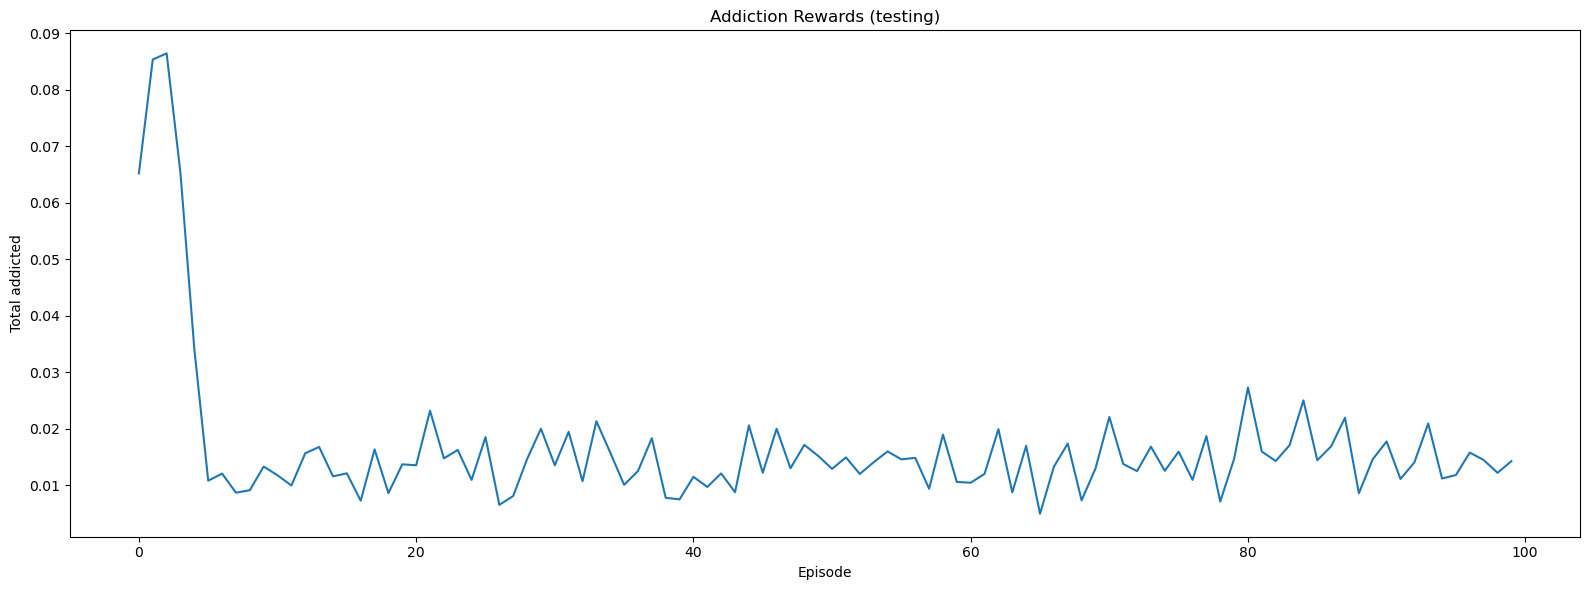

In [44]:
#plot
#print(sys.getsizeof(stds))
timestamps = np.arange(T)
plt.figure(figsize=(10, 6))
plt.errorbar(timestamps, meansA, yerr=stdsA, fmt='o', capsize=5, label='Addicted')
plt.errorbar(timestamps, meansH, yerr=stdsH, fmt='o', capsize=5, label='Healthy', color='pink')
plt.xlabel('Timestamps')
plt.ylabel('Values')
plt.title('Means and Standard Deviations over Timestamps')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(addiction_states)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')
plt.tight_layout()
plt.show()